# Text Mining 10K fillings to predict financial distress (EDF) (2012 - 2016) 

- Exploratory data analysis and data visualization 
- Text mining: Tokenization, TFIDF, WordCloud, Sentiment Analysis

In [24]:
import numpy as np
import pandas as pd
import re
import os
from os import listdir
import gensim
from gensim import corpora
from pprint import pprint
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import nltk
import string
from gensim.utils import simple_preprocess
from smart_open import smart_open
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
#word cloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [25]:
# load data - index file with risk_factor_text 
kmv_data_RiskFactor = pd.read_csv("../code/output/index_kmv_data_RiskFactor.csv")

In [26]:
kmv_data_RiskFactor.sample(5)

,Unnamed: 0,Unnamed: 0.1,gvkey,year,edf,actual_10k_path_raw,risk_factor_text
6918,6918,7741,63123,2012,1.086835e-04,edgar/data/1012620/0001012620-12-000003.txt,NaN
5391,5391,5978,25937,2015,7.832484e-09,edgar/data/886163/0000886163-15-000028.txt,"."" Government Regulation The manufacturing and..."
2666,2666,2842,9590,2014,4.360116e-03,edgar/data/88790/0000897101-14-000317.txt,**_ You should carefully consider the risks de...
6500,6500,7274,61188,2014,3.269779e-17,edgar/data/945394/0001047469-14-001548.txt,** Our business faces many risks. The risks d...
5219,5219,5786,25283,2013,6.677098e-04,edgar/data/885639/0000885639-13-000004.txt,Forward-Looking Statements This Form 10-K con...


In [27]:
kmv_data_RiskFactor.shape

(12103, 7)

In [28]:
#drop rows with Null values
kmv_data_RiskFactor_dropna = kmv_data_RiskFactor.dropna(how='any')

In [29]:
kmv_data_RiskFactor_dropna.shape
#> (11581, 7)

(11581, 7)

# kmv_data_RiskFactor_dropna[:5]

### Data Stucture

In [ ]:
risk_factor_text = kmv_data_RiskFactor_dropna['risk_factor_text'].tolist()

In [31]:
#remove '\n' + ‘\\n’
risk_factor_text = list(map(lambda i: str(i).replace('\n', ' '), risk_factor_text))

In [33]:
kmv_data_RiskFactor_sort = kmv_data_RiskFactor_dropna.sort_values(by=['year', 'edf'], 
                                                           ascending = [True, False])
kmv_data_RiskFactor_sort.sample(20)

,Unnamed: 0,Unnamed: 0.1,gvkey,year,edf,actual_10k_path_raw,risk_factor_text
11760,11760,13537,186823,2012,8.694596e-19,edgar/data/1452857/0000921895-12-000606.txt,Our business is subject to a number of risks....
9842,9842,11211,164494,2015,6.216303e-14,edgar/data/1364885/0001628280-15-000760.txt,An investment in our securities involves risk...
2968,2968,3175,10735,2016,2.366123e-01,edgar/data/99780/0000099780-16-000164.txt,"with regard to environmental, governmental, a..."
11728,11728,13500,186591,2015,5.433585e-09,edgar/data/1508171/0001193125-15-062566.txt,** _An investment in our securities involves c...
3454,3454,3692,12392,2016,3.330945e-05,edgar/data/793733/0001558370-16-003629.txt,15
2839,2839,3035,10190,2016,4.638390e-01,edgar/data/95521/0000095521-16-000192.txt,Various risks and uncertainties may affect th...
7550,7550,8480,65884,2015,3.918400e-03,edgar/data/1028954/0001028954-15-000002.txt,9
8122,8122,9169,119314,2013,3.116559e-19,edgar/data/1075531/0001075531-13-000011.txt,"."" Unless required by law, we undertake no obl..."
2573,2573,2744,9063,2016,6.037409e-02,edgar/data/350698/0000350698-16-000276.txt,"Our business, financial condition, results of..."
1500,1500,1612,5763,2014,2.109463e-12,edgar/data/1029800/0001029800-14-000005.txt,. _Compliance with Governmental Regulations_ T...


In [24]:
kmv_data_RiskFactor_sort.dtypes

Unnamed: 0               int64
Unnamed: 0.1             int64
gvkey                    int64
year                     int64
edf                    float64
actual_10k_path_raw     object
risk_factor_text        object
dtype: object

In [25]:
kmv_data_RiskFactor_sort.shape
#> (11581, 7)

(11581, 7)

### Basic Statistics

In [26]:
# mean and std of edf groupby year
edf_mean_std = kmv_data_RiskFactor_sort.groupby('year').edf.aggregate([np.mean,np.std])
edf_mean_std

,mean,std
year,,
2012,0.080642,0.181910
2013,0.035892,0.116287
2014,0.045216,0.129235
2015,0.112202,0.233193
2016,0.126705,0.253775


In [27]:
#length of texts
length = [len(re.findall(r'\w+', i)) for i in risk_factor_text]

In [28]:
max_length = max(length)
max_length

67476

In [29]:
min_length = min(length)
min_length

1

In [ ]:
length_1 = [i for i in risk_factor_text if len(re.findall(r'\w+', i)) == 1]
length_1

In [31]:
#number of text with only numbers
len(length_1)

281

In [34]:
#drop rows that text length = 1 
##Won't use this dataset for text mining as gensim can automatically remove number/punctuation when tokenization
kmv_data_RiskFactor_sort_filtered = kmv_data_RiskFactor_sort[kmv_data_RiskFactor_sort['risk_factor_text'].map(
    lambda x: len(re.findall(r'\w+', x)) != 1)]

In [33]:
len(kmv_data_RiskFactor_sort_filtered)
#>11293

11300

In [34]:
kmv_data_RiskFactor_sort.shape

(11581, 7)

In [35]:
#Company distribution by year
companies_by_year = kmv_data_RiskFactor_sort.groupby('year').size()
companies_by_year = pd.DataFrame(companies_by_year).reset_index()
companies_by_year.columns = ['year','number of companies']
companies_by_year

,year,number of companies
0,2012,2275
1,2013,2309
2,2014,2327
3,2015,2330
4,2016,2340


/Users/iriswang/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Company distribution by year')

(2200, 2400)

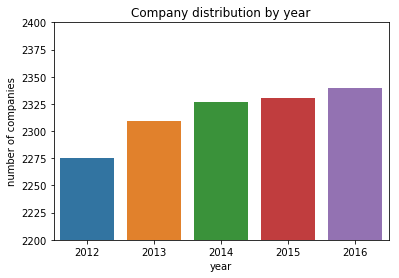

In [36]:
#plotting
sns.barplot(x = 'year', y = 'number of companies', data = companies_by_year)
plt.title("Company distribution by year") 
plt.ylim(2200, 2400)
plt.show() 

/Users/iriswang/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/Users/iriswang/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Financial distress score distribution by year')

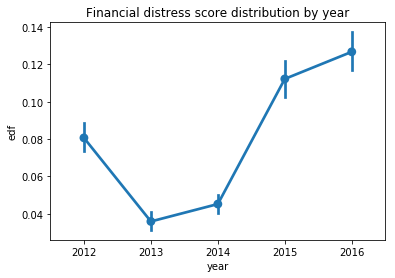

In [37]:
#Financial distress distribution - show point estimates and confidence intervals 
sns.pointplot(x = 'year', y = 'edf', data = kmv_data_RiskFactor_sort)
plt.title("Financial distress score distribution by year") 
plt.show() 

### Find outliners / significant score for each year

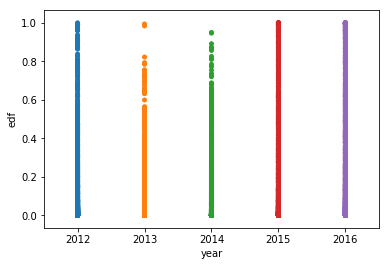

In [38]:
#find outliners for each year's edf score
sns.stripplot(x='year',y='edf',data=kmv_data_RiskFactor_sort)
plt.show() 

#### 2012

In [39]:
#2012
kmv_2012 = kmv_data_RiskFactor_sort.loc[(kmv_data_RiskFactor_sort.year == 2012)]
kmv_2012[0:10]

,Unnamed: 0,Unnamed: 0.1,gvkey,year,edf,actual_10k_path_raw,risk_factor_text
5283,5283,5855,25495,2012,0.999451,edgar/data/1379895/0001047469-12-002275.txt,_** **FORWARD-LOOKING STATEMENTS ** This Form...
9365,9365,10641,160375,2012,0.990689,edgar/data/1289340/0001193125-12-117497.txt, and elsewhere in this annual report on Form ...
8550,8550,9684,137371,2012,0.989679,edgar/data/1091325/0001213900-12-001386.txt,". Because of the following factors, as well as..."
10348,10348,11849,175674,2012,0.989441,edgar/data/1270436/0001193125-12-105937.txt,". Accordingly, such information should not be..."
5068,5068,5615,24658,2012,0.987846,edgar/data/837852/0001140361-12-018388.txt,""" included herein, as well as assumptions, whi..."
8665,8665,9834,140938,2012,0.984754,edgar/data/1290476/0001002105-12-000040.txt,"and the section captioned ""Caution About Forw..."
9344,9344,10616,160282,2012,0.984555,edgar/data/1287151/0001193125-12-113802.txt,"** Our\nbusiness, results of operations and fi..."
4711,4711,5235,20791,2012,0.975788,edgar/data/1061630/0001193805-12-000210.txt,FORWARD LOOKING INFORMATION Our Annual Report...
8376,8376,9468,126555,2012,0.967976,edgar/data/1089511/0001193125-12-094359.txt," and Item 7, Managements Discussion and Ana..."
8978,8978,10211,148239,2012,0.962771,edgar/data/1106644/0001010549-12-000255.txt,Risks Related to our Business and our Industr...


In [ ]:
#top1 score in 2012 - 9.994514e-01
kmv_data_RiskFactor_sort.loc[5283,'risk_factor_text']
#company name:DYNEGY INC.
#industry:ELECTRIC SERVICES 
#ACCESSION NUMBER:0001047469-12-002275

In [ ]:
#top2 score in 2012 - 9.906893e-01
kmv_data_RiskFactor_sort.loc[9365,'risk_factor_text']
#company name:Stereotaxis, Inc.
#industry:ELECTROMEDICAL & ELECTROTHERAPEUTIC APPARATUS 
#ACCESSION NUMBER:0001193125-12-117497

In [ ]:
#top3 score in 2012 - 9.896786e-01
kmv_data_RiskFactor_sort.loc[8550,'risk_factor_text']
#company name:CHINA YIDA HOLDING, CO.
#industry:SERVICES-ADVERTISING 
#ACCESSION NUMBER:0001213900-12-001386

In [43]:
#2012 - lowest scores
kmv_data_RiskFactor_sort.loc[(kmv_data_RiskFactor_sort.year == 2012)][-10:]

,Unnamed: 0,Unnamed: 0.1,gvkey,year,edf,actual_10k_path_raw,risk_factor_text
2594,2594,2770,9248,2012,4.263767e-66,edgar/data/745732/0001206774-12-001210.txt,.** Our Annual Report on Form 10-K for\nfiscal...
7282,7282,8177,64901,2012,7.669887e-70,edgar/data/1032220/0001104659-12-078644.txt,._** Our operations are subject to many risks ...
6616,6616,7414,61581,2012,1.410054e-73,edgar/data/949870/0001193125-12-072823.txt,_** **** In\naddition to the other information...
5160,5160,5710,24975,2012,2.870437e-77,edgar/data/883241/0001193125-12-510596.txt,_ of this Form 10-K. The information included ...
5145,5145,5695,24893,2012,1.405600e-77,edgar/data/865436/0000865436-12-000033.txt,""" for a discussion of risks and uncertainties ..."
7912,7912,8958,112111,2012,4.568787e-80,edgar/data/1057352/0001057352-12-000024.txt,""" below. The LoopNet transaction is not subjec..."
6666,6666,7469,61732,2012,3.837236e-82,edgar/data/1003078/0001144204-12-058651.txt," and Item 7, Managements Discussion and Ana..."
1732,1732,1855,6435,2012,3.046964e-95,edgar/data/55785/0000055785-12-000021.txt,"."" Competition We have several major competito..."
8759,8759,9950,143357,2012,3.357222e-98,edgar/data/1467373/0001467373-12-000170.txt,In addition to the other information set fort...
3609,3609,3863,12825,2012,1.338727e-144,edgar/data/785956/0001437749-12-012188.txt,You should carefully consider the risks descr...


In [ ]:
#top1 lowest score in 2012 - 1.338727e-144
kmv_data_RiskFactor_sort.loc[3609,'risk_factor_text']
#company name:J&J; SNACK FOODS CORP
#industry:COOKIES & CRACKERS
#ACCESSION NUMBER:0001437749-12-012188

In [ ]:
#top2 lowest score in 2012 - 3.357222e-98
kmv_data_RiskFactor_sort.loc[8759,'risk_factor_text']
#company name:Accenture plc
#industry:SERVICES-BUSINESS SERVICES, NEC 
#ACCESSION NUMBER:0001467373-12-000170

In [ ]:
#top3 lowest score in 2012 - 3.046964e-95
kmv_data_RiskFactor_sort.loc[1732,'risk_factor_text']
#company name:KIMBERLY CLARK CORP
#industry:CONVERTED PAPER & PAPERBOARD PRODS
#ACCESSION NUMBER:0000055785-12-000021

#### 2013

In [47]:
#2013
kmv_data_RiskFactor_sort.loc[(kmv_data_RiskFactor_sort.year == 2013)]

,Unnamed: 0,Unnamed: 0.1,gvkey,year,edf,actual_10k_path_raw,risk_factor_text
9603,9603,10913,162346,2013,9.935292e-01,edgar/data/1419242/0001047469-13-001975.txt,_. Our business is both highly competitive and...
11354,11354,13063,184569,2013,9.835502e-01,edgar/data/1412347/0001437749-13-003793.txt,31 --- Item 1B. Unresolved Staff Comments 53 ...
6414,6414,7183,32280,2013,8.220201e-01,edgar/data/1507934/0001507934-13-000015.txt,The risks described below and elsewhere in th...
8397,8397,9489,127383,2013,7.931587e-01,edgar/data/1086745/0001144204-13-041652.txt,** ** ** **The report of our independent regis...
6627,6627,7425,61586,2013,7.842242e-01,edgar/data/1000298/0001047469-13-002555.txt,""" and Item 7. ""Management's Discussion and Ana..."
4687,4687,5181,20488,2013,7.558327e-01,edgar/data/903571/0000903571-13-000005.txt,You should consider the following discussion ...
8137,8137,9189,119714,2013,7.513766e-01,edgar/data/1464343/0001464343-13-000004.txt,and other cautionary statements in other docu...
10656,10656,12230,177734,2013,7.360671e-01,edgar/data/1392363/0001062993-13-004777.txt,** 16 * * * _An investment in our common stock...
2870,2870,3067,10380,2013,7.349783e-01,edgar/data/96793/0001193125-13-382169.txt,_** **** --- In addition to other information ...
7448,7448,8368,65587,2013,7.266356e-01,edgar/data/70487/0001437749-13-002206.txt,You should carefully consider each of the ris...


In [ ]:
#top1 score in 2013 - 9.935292e-01
kmv_data_RiskFactor_sort.loc[9603,'risk_factor_text']
#Company name: ATLANTIC POWER CORP
#Industry: ELECTRIC, GAS & SANITARY SERVICES
#ACCESSION NUMBER:0001047469-13-001975

In [ ]:
#top 2 score in 2013 - 9.835502e-01
kmv_data_RiskFactor_sort.loc[11354,'risk_factor_text']
#company name: Oxford Resource Partners LP
#industry: BITUMINOUS COAL & LIGNITE SURFACE
#ACCESSION NUMBER:0001437749-13-003793

In [ ]:
#top 3 score in 2013 - 8.220201e-01
kmv_data_RiskFactor_sort.loc[6414,'risk_factor_text']
#company name: Starz
#industry: CABLE & OTHER PAY TELEVISION 
#ACCESSION NUMBER:0001507934-13-000015

In [51]:
#lowest score in 2013
kmv_data_RiskFactor_sort.loc[(kmv_data_RiskFactor_sort.year == 2013)][-10:]

,Unnamed: 0,Unnamed: 0.1,gvkey,year,edf,actual_10k_path_raw,risk_factor_text
5161,5161,5711,24975,2013,1.476659e-95,edgar/data/883241/0001193125-13-479653.txt,_ of this Form 10-K. The\ninformation included...
2128,2128,2271,7759,2013,1.386799e-101,edgar/data/70415/0001144204-13-011131.txt,and those other risks and uncertainties detai...
7045,7045,7887,63763,2013,5.251340e-102,edgar/data/1017480/0001017480-13-000010.txt,. You should carefully consider the following ...
390,390,422,2312,2013,1.643116e-103,edgar/data/315213/0001193125-13-062356.txt,** The Companys business prospects are subje...
5116,5116,5666,24800,2013,3.413592e-104,edgar/data/804328/0001234452-13-000483.txt,You should consider each of the following fac...
9850,9850,11229,164557,2013,1.790504e-114,edgar/data/1324948/0001144204-13-032047.txt,- Future reductions or changes in U.S. govern...
7668,7668,8604,66446,2013,3.229812e-126,edgar/data/1050915/0001193125-13-087221.txt,_ for additional information. 6 * * * ##### T...
7283,7283,8178,64901,2013,2.739637e-130,edgar/data/1032220/0001047469-13-010633.txt,. _** Our operations are subject to many risks...
11488,11488,13213,185229,2013,3.802443e-148,edgar/data/1486957/0001193125-13-080935.txt,18 Item 1B. Unresolved Staff Comments 34 Item...
3610,3610,3864,12825,2013,2.728538e-210,edgar/data/785956/0001437749-13-015349.txt,** You should carefully consider the risks des...


In [ ]:
#top1 lowest score in 2013 - 2.728538e-210
kmv_data_RiskFactor_sort.loc[3610,'risk_factor_text']
#company name:J&J; SNACK FOODS CORP
#industry:COOKIES & CRACKERS
#ACCESSION NUMBER:0001437749-13-015349

In [ ]:
#top2 lowest score in 2013 - 3.802443e-148
kmv_data_RiskFactor_sort.loc[11488,'risk_factor_text']
#company name:Babcock & Wilcox Co
#industry:ENGINES & TURBINES 
#ACCESSION NUMBER:0001193125-13-080935

In [54]:
#top3 lowest score in 2013 - 2.739637e-130
kmv_data_RiskFactor_sort.loc[7283,'risk_factor_text']
#company name:MAXIMUS INC
#industry:SERVICES-BUSINESS SERVICES, NEC
#ACCESSION NUMBER:0001047469-13-010633

'. _** Our operations are subject to many risks that could adversely affect our future financial condition and performance and, therefore, the\nmarket value of our securities. See Exhibit 99.1 of this Annual Report on Form 10-K under the caption "Special Considerations and Risk Factors" for information on risks and uncertainties\nthat could affect our future financial condition and performance. The information in Exhibit 99.1 is incorporated by reference into this Item 1A. 14 * * * Table of Contents **'

#### 2014

In [ ]:
#2014
kmv_data_RiskFactor_sort.loc[(kmv_data_RiskFactor_sort.year == 2014)]

In [ ]:
#top 1 score in 2014 - 9.493184e-01
kmv_data_RiskFactor_sort.loc[7699,'risk_factor_text']
#company name: ANWORTH MORTGAGE ASSET CORP
#industry: REAL ESTATE INVESTMENT TRUSTS
#ACCESSION NUMBER:0001564590-14-000364

In [ ]:
#top 2 score in 2014 - 9.462163e-01
kmv_data_RiskFactor_sort.loc[11772,'risk_factor_text']
#company name: American Capital Mortgage 
#industry: REAL ESTATE INVESTMENT TRUSTS
#ACCESSION NUMBER:0001516973-14-000015

In [ ]:
#top 3 score in 2014 - 8.909815e-01
kmv_data_RiskFactor_sort.loc[5522,'risk_factor_text']
#company name: AMARIN CORP PLC\UK
#industry: PHARMACEUTICAL PREPARATIONS
#ACCESSION NUMBER:0001193125-14-072975

In [59]:
#2014
kmv_data_RiskFactor_sort.loc[(kmv_data_RiskFactor_sort.year == 2014)][-10:]

,Unnamed: 0,Unnamed: 0.1,gvkey,year,edf,actual_10k_path_raw,risk_factor_text
1654,1654,1777,6266,2014,1.503074e-75,edgar/data/200406/0000200406-14-000033.txt,Some important factors that could cause the C...
1346,1346,1441,5254,2014,7.672743e-76,edgar/data/716314/0001193125-14-224704.txt,_** **** Our business and operations are subje...
6618,6618,7416,61581,2014,1.594971e-91,edgar/data/949870/0001193125-14-067410.txt,_** **** In\naddition to the other information...
4818,4818,5347,23084,2014,1.563628e-128,edgar/data/863436/0000863436-14-000006.txt,._** **Adverse market conditions in the\nelect...
7284,7284,8179,64901,2014,4.407005e-212,edgar/data/1032220/0001047469-14-009278.txt,._** Our\noperations are subject to many risks...
391,391,423,2312,2014,4.367033e-244,edgar/data/315213/0001193125-14-054441.txt,\n** The Companys business prospects are subj...
3611,3611,3865,12825,2014,2.801707e-264,edgar/data/785956/0001437749-14-021361.txt,** You should carefully consider the risks des...
5851,5851,6537,29206,2014,2.766157e-290,edgar/data/912728/0000912728-14-000009.txt,In addition to the other information in this ...
5117,5117,5667,24800,2014,4.502670e-301,edgar/data/804328/0001234452-14-000320.txt,You should consider each of the following fac...
8761,8761,9952,143357,2014,0.000000e+00,edgar/data/1467373/0001467373-14-000467.txt,In addition to the other information set fort...


In [ ]:
#top1 lowest score in 2014 - 0.000000e+00
kmv_data_RiskFactor_sort.loc[8761,'risk_factor_text']
#company name:Accenture plc
#industry:SERVICES-BUSINESS SERVICES, NEC 
#ACCESSION NUMBER:0001467373-14-000467

In [ ]:
#top2 lowest score in 2014 - 4.502670e-301
kmv_data_RiskFactor_sort.loc[5117,'risk_factor_text']
#company name:QUALCOMM INC/DE
#industry:RADIO & TV BROADCASTING & COMMUNICATIONS EQUIPMENT
#ACCESSION NUMBER:0001234452-14-000320

In [ ]:
#top3 lowest score in 2014 - 2.766157e-290
kmv_data_RiskFactor_sort.loc[5851,'risk_factor_text']
#company name:FORWARD AIR CORP
#industry:ARRANGEMENT OF TRANSPORTATION OF FREIGHT & CARGO 
#ACCESSION NUMBER:0000912728-14-000009

#### 2015

In [ ]:
#2015
kmv_data_RiskFactor_sort.loc[(kmv_data_RiskFactor_sort.year == 2015)]

In [ ]:
#top 1 score in 2015 - 9.999963e-01
kmv_data_RiskFactor_sort.loc[10053,'risk_factor_text']
#company name: Atlas Energy Group, LLC
#industry: CRUDE PETROLEUM & NATURAL GAS 
#ACCESSION NUMBER:0001193125-15-109641

In [ ]:
#top 2 score in 2015 - 9.999791e-01
kmv_data_RiskFactor_sort.loc[608,'risk_factor_text']
#company name: CLIFFS NATURAL RESOURCES INC.
#industry: METAL MINING
#ACCESSION NUMBER:0000764065-15-000044

In [ ]:
#top 3 score in 2015 - 9.998494e-01
kmv_data_RiskFactor_sort.loc[8733,'risk_factor_text']
#company name: PEABODY ENERGY CORP
#industry: BITUMINOUS COAL & LIGNITE SURFACE MINING
#ACCESSION NUMBER:0001064728-15-000021

In [67]:
#2015
kmv_data_RiskFactor_sort.loc[(kmv_data_RiskFactor_sort.year == 2015)][-10:]

,Unnamed: 0,Unnamed: 0.1,gvkey,year,edf,actual_10k_path_raw,risk_factor_text
3344,3344,3575,11811,2015,8.471088e-62,edgar/data/779152/0000779152-15-000056.txt,The Company's business and the results of its...
3737,3737,3996,13341,2015,4.116992e-62,edgar/data/80661/0000080661-15-000010.txt,Progressive's business involves various risks...
7865,7865,8906,111064,2015,5.419600e-63,edgar/data/1016125/0001016125-15-000006.txt,Ultimate operates in a rapidly changing and d...
9763,9763,11126,163891,2015,2.996275e-75,edgar/data/1324272/0001437749-15-004629.txt,", in this Annual Report on Form 10-K as well a..."
2821,2821,3009,10096,2015,9.775108e-78,edgar/data/1393311/0001393311-15-000005.txt,""" and in our other filings with the Securities..."
6511,6511,7290,61302,2015,1.783971e-86,edgar/data/947484/0000947484-15-000010.txt,","" Item 7 ""Management's Discussion and Analysi..."
6619,6619,7417,61581,2015,4.972331e-89,edgar/data/949870/0001193125-15-060122.txt,** In addition to the other information in thi...
2942,2942,3144,10609,2015,2.536875e-94,edgar/data/98677/0001558370-15-000212.txt,5
392,392,424,2312,2015,6.419198e-158,edgar/data/315213/0001628280-15-000736.txt,The Company's business prospects are subject ...
8762,8762,9953,143357,2015,7.784852e-170,edgar/data/1467373/0001467373-15-000457.txt,In addition to the other information set fort...


In [ ]:
#top1 lowest score in 2015 - 7.784852e-170
kmv_data_RiskFactor_sort.loc[8762,'risk_factor_text']
#company name:Accenture plc
#industry:SERVICES-BUSINESS SERVICES, NEC 
#ACCESSION NUMBER:0001467373-15-000457

In [ ]:
#top2 lowest score in 2015 - 6.419198e-158
kmv_data_RiskFactor_sort.loc[392,'risk_factor_text']
#company name:HALF ROBERT INTERNATIONAL IN
#industry:SERVICES-HELP SUPPLY SERVICES 
#ACCESSION NUMBER:0001628280-15-000736

In [70]:
#top3 lowest score in 2015 - 2.536875e-94
kmv_data_RiskFactor_sort.loc[2942,'risk_factor_text']
#company name:TOOTSIE ROLL INDUSTRIES INC
#industry:SUGAR & CONFECTIONERY PRODUCTS 
#ACCESSION NUMBER:0001558370-15-000212

' 5 '

#### 2016

In [ ]:
#2016
kmv_data_RiskFactor_sort.loc[(kmv_data_RiskFactor_sort.year == 2016)]

In [ ]:
#top 1 score in 2016 - 9.999997e-01
kmv_data_RiskFactor_sort.loc[8734,'risk_factor_text']
#company name: PEABODY ENERGY CORP
#industry: BITUMINOUS COAL & LIGNITE SURFACE MINING
#ACCESSION NUMBER:0001064728-16-000157

In [ ]:
#top 2 score in 2016 - 9.999834e-01
kmv_data_RiskFactor_sort.loc[10054,'risk_factor_text']
#company name: Atlas Energy Group, LLC
#industry: CRUDE PETROLEUM & NATURAL GAS
#ACCESSION NUMBER:0001564590-16-015676

In [ ]:
#top 3 score in 2016 - 9.999460e-01
kmv_data_RiskFactor_sort.loc[9204,'risk_factor_text']
#company name: Cinedigm Corp.
#industry: SERVICES-VIDEO TAPE RENTAL
#ACCESSION NUMBER:0001628280-16-017605

In [75]:
#2016
kmv_data_RiskFactor_sort.loc[(kmv_data_RiskFactor_sort.year == 2016)][-10:]

,Unnamed: 0,Unnamed: 0.1,gvkey,year,edf,actual_10k_path_raw,risk_factor_text
5564,5564,6174,28180,2016,8.859560e-51,edgar/data/898173/0000898173-16-000276.txt,"Unless otherwise indicated, ""we,"" ""us,"" ""our""..."
2483,2483,2649,8599,2016,8.511674e-58,edgar/data/78749/0000078749-16-000080.txt,. Risks Relating to Our Business Our future su...
244,244,259,1891,2016,4.254377e-59,edgar/data/8670/0000008670-16-000053.txt,Our businesses routinely encounter and addres...
3345,3345,3576,11811,2016,1.070893e-73,edgar/data/779152/0000779152-16-000142.txt,The Company's business and the results of its...
393,393,425,2312,2016,1.709924e-75,edgar/data/315213/0001628280-16-011322.txt,The Company's business prospects are subject ...
5923,5923,6614,29517,2016,4.602795e-79,edgar/data/910329/0001144204-16-088200.txt,** ** ** You should consider\ncarefully the fo...
7866,7866,8907,111064,2016,4.196283e-79,edgar/data/1016125/0001016125-16-000168.txt,Ultimate operates in a rapidly changing and d...
2943,2943,3145,10609,2016,3.495993e-107,edgar/data/98677/0001558370-16-003574.txt,5
8763,8763,9954,143357,2016,4.582400e-111,edgar/data/1467373/0001467373-16-001080.txt,In addition to the other information set fort...
3613,3613,3867,12825,2016,0.000000e+00,edgar/data/785956/0001437749-16-042541.txt,** You should carefully consider the risks des...


In [ ]:
#top1 lowest score in 2016 - 0.000000e+00	
kmv_data_RiskFactor_sort.loc[3613,'risk_factor_text']
#company name:J&J; SNACK FOODS CORP
#industry:COOKIES & CRACKERS
#ACCESSION NUMBER:0001437749-16-042541

In [ ]:
#top2 lowest score in 2016 - 4.582400e-111
kmv_data_RiskFactor_sort.loc[8763,'risk_factor_text']
#company name:Accenture plc
#industry:SERVICES-BUSINESS SERVICES, NEC 
#ACCESSION NUMBER:0001467373-16-001080

In [78]:
#top3 lowest score in 2016 - 3.495993e-107
kmv_data_RiskFactor_sort.loc[2943,'risk_factor_text']
#company name:TOOTSIE ROLL INDUSTRIES INC
#industry:SUGAR & CONFECTIONERY PRODUCTS 
#ACCESSION NUMBER:0001558370-16-003574

' 5 '

### Top 10 low edf score - low financial distress

In [79]:
kmv_edf_10_low = kmv_data_RiskFactor_sort.sort_values(by=['edf'])[:10]
kmv_edf_10_low

,Unnamed: 0,Unnamed: 0.1,gvkey,year,edf,actual_10k_path_raw,risk_factor_text
3613,3613,3867,12825,2016,0.000000e+00,edgar/data/785956/0001437749-16-042541.txt,** You should carefully consider the risks des...
8761,8761,9952,143357,2014,0.000000e+00,edgar/data/1467373/0001467373-14-000467.txt,In addition to the other information set fort...
5117,5117,5667,24800,2014,4.502670e-301,edgar/data/804328/0001234452-14-000320.txt,You should consider each of the following fac...
5851,5851,6537,29206,2014,2.766157e-290,edgar/data/912728/0000912728-14-000009.txt,In addition to the other information in this ...
3611,3611,3865,12825,2014,2.801707e-264,edgar/data/785956/0001437749-14-021361.txt,** You should carefully consider the risks des...
391,391,423,2312,2014,4.367033e-244,edgar/data/315213/0001193125-14-054441.txt,\n** The Companys business prospects are subj...
7284,7284,8179,64901,2014,4.407005e-212,edgar/data/1032220/0001047469-14-009278.txt,._** Our\noperations are subject to many risks...
3610,3610,3864,12825,2013,2.728538e-210,edgar/data/785956/0001437749-13-015349.txt,** You should carefully consider the risks des...
8762,8762,9953,143357,2015,7.784852e-170,edgar/data/1467373/0001467373-15-000457.txt,In addition to the other information set fort...
392,392,424,2312,2015,6.419198e-158,edgar/data/315213/0001628280-15-000736.txt,The Company's business prospects are subject ...


(-0.5, 799.5, 399.5, -0.5)

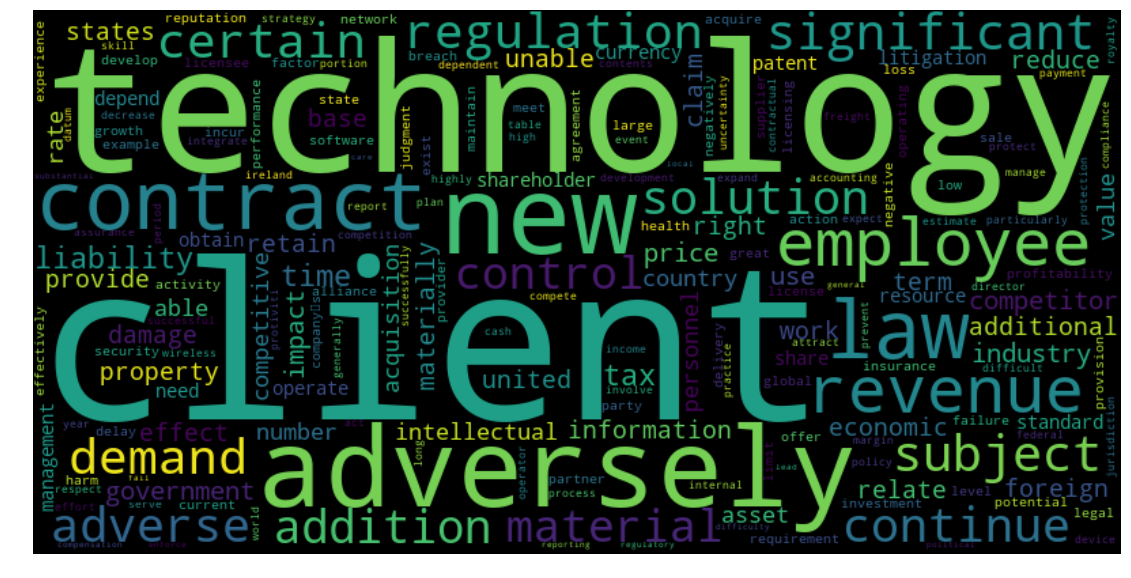

In [80]:
import spacy
nlp = spacy.load('en')
from gensim.parsing.preprocessing import *

def new_tokenization_list(texts):
    
    new_tokenization_list = []
    
    CUSTOM_FILTERS = [strip_tags, strip_punctuation,
                      strip_numeric, remove_stopwords, strip_short]
    
    for text in texts:
        
        #tokenization
        tokenized_text = preprocess_string(' '.join([w.lemma_ for w in nlp(text)]), CUSTOM_FILTERS)
        #remove'PRON' got from lemmatization
        tokenized_text = [token for token in tokenized_text if token != 'PRON']
        
        new_tokenization_list.append(tokenized_text)
    
    return new_tokenization_list

tokenization_10_low = new_tokenization_list(kmv_edf_10_low.risk_factor_text)
#remove general words
to_be_removed = ['result','business','product','financial','company','include','operation','market','service',
                 'affect','risk','cost','condition','increase','customer','change','require','future','ability',
                'dispositions\x94','hearing\x94','leif','noteholders\x94','objections','pink\x94','vacate\x94',
                 '\x93confirmation','\x93ds','\x93egc','\x93egc\x94','\x93exxi\x94','\x93fourteenth','\x93mk\x94',
                 '\x93petition','\x93thirteenth','\x93ucc\x94','kanis','ock','\x93\x97historically']
clean_tokenization_10_low = [[token for token in text if token not in to_be_removed] 
                           for text in tokenization_10_low]
#create dict and corpos
mydict_10_low = corpora.Dictionary()
mycorpus_10_low = [mydict_10_low.doc2bow(doc, allow_update=True) for doc in clean_tokenization_10_low]
word_counts_10_low = [[(mydict_10_low[id], count)for id, count in line] for line in mycorpus_10_low]

#create dictionary for all docs
dict_word_counts_10_low = {}
for i in word_counts_10_low:
    for w, f in i:
        if w not in dict_word_counts_10_low.keys():
            dict_word_counts_10_low[w] = f
        else:
            dict_word_counts_10_low[w] += f

#wordcloud
wordcloud = WordCloud(width=800, height=400)
wordcloud.generate_from_frequencies(frequencies=dict_word_counts_10_low)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [81]:
#most frequency words from the top 10 lowest edf score
word_counts_10_low = list(dict_word_counts_10_low.items())
word_counts_10_low = sorted(word_counts_10_low, key=lambda x: x[1], reverse = True)
word_counts_10_low = word_counts_10_low[0:20]
word_counts_10_low = dict(word_counts_10_low)
word_counts_10_low

{'addition': 99,
 'adverse': 101,
 'adversely': 157,
 'certain': 108,
 'client': 238,
 'continue': 103,
 'contract': 143,
 'control': 97,
 'demand': 111,
 'employee': 131,
 'law': 139,
 'liability': 95,
 'material': 98,
 'new': 152,
 'regulation': 106,
 'revenue': 124,
 'significant': 115,
 'solution': 100,
 'subject': 115,
 'technology': 159}

<Container object of 20 artists>

Text(0.5,0,'Words')

([<matplotlib.axis.XTick at 0x1a726f6ac8>,
 <a list of 20 Text xticklabel objects>)

(80, 250)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

Text(0.5,1,'Top 20 Frequent Words from top 10 lowest Financial Distress Texts')

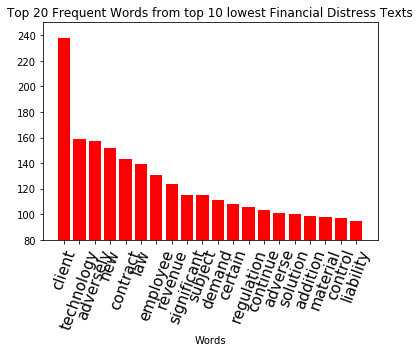

In [82]:
from matplotlib.pyplot import figure
plt.bar(range(len(word_counts_10_low)), word_counts_10_low.values(), align='center', 
        color = 'red')
plt.xlabel('Words', fontsize=10)
plt.xticks(range(len(word_counts_10_low)), word_counts_10_low.keys(), fontsize = 15)
plt.ylim(80, 250)
plt.xticks(rotation=70)
plt.rcParams["figure.figsize"] = [16,9]
plt.title('Top 20 Frequent Words from top 10 lowest Financial Distress Texts')
plt.show()

### Top 10 highest edf score - high financial distress

In [83]:
kmv_edf_10_high = kmv_data_RiskFactor_sort.sort_values(by=['edf'])[-10:]
kmv_edf_10_high

,Unnamed: 0,Unnamed: 0.1,gvkey,year,edf,actual_10k_path_raw,risk_factor_text
9813,9813,11177,164109,2016,0.999740,edgar/data/1326428/0001326428-16-000071.txt,"."" References When referring to Linn Energy, L..."
8867,8867,10084,145979,2016,0.999785,edgar/data/817979/0000817979-16-000058.txt,Factors That May Affect Future Results In thi...
7766,7766,8782,108645,2016,0.999817,edgar/data/1022646/0001193125-16-484243.txt,. **Oil and Gas Properties Overview** **_Princ...
8733,8733,9917,142460,2015,0.999849,edgar/data/1064728/0001064728-15-000021.txt,. We operate in a rapidly changing environment...
9739,9739,11092,163685,2016,0.999881,edgar/data/1322439/0001437749-16-028714.txt,** _We operate in an intensely competitive ind...
9204,9204,10465,155616,2016,0.999946,edgar/data/1173204/0001628280-16-017605.txt,""" and Item 7, ""Management's Discussion and Ana..."
608,608,679,3107,2015,0.999979,edgar/data/764065/0000764065-15-000044.txt,21 Item 1B. Unresolved Staff Comments 32 Item...
10054,10054,11502,166458,2016,0.999983,edgar/data/1623595/0001564590-16-015676.txt,""" of this annual report. Given these risks and..."
10053,10053,11501,166458,2015,0.999996,edgar/data/1623595/0001193125-15-109641.txt, of this annual report. Given these risks and...
8734,8734,9918,142460,2016,1.000000,edgar/data/1064728/0001064728-16-000157.txt,. We operate in a rapidly changing environment...


(-0.5, 799.5, 399.5, -0.5)

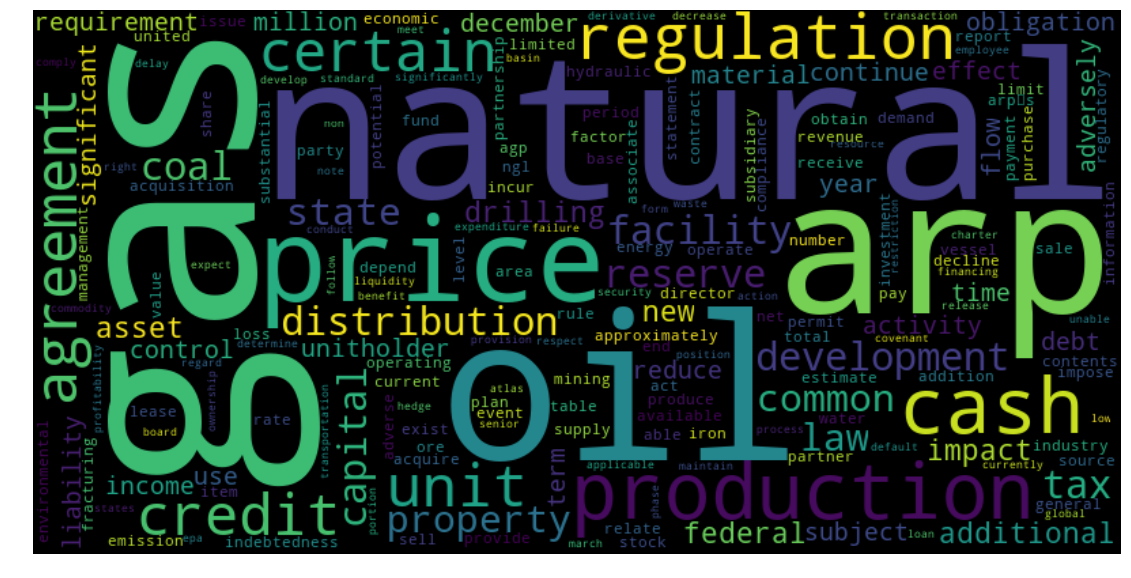

In [84]:
tokenization_10_high = new_tokenization_list(kmv_edf_10_high.risk_factor_text)
#remove general words
to_be_removed = ['result','business','product','financial','company','include','operation','market','service',
                 'affect','risk','cost','condition','increase','customer','change','require','future','ability',
                'dispositions\x94','hearing\x94','leif','noteholders\x94','objections','pink\x94','vacate\x94',
                 '\x93confirmation','\x93ds','\x93egc','\x93egc\x94','\x93exxi\x94','\x93fourteenth','\x93mk\x94',
                 '\x93petition','\x93thirteenth','\x93ucc\x94','kanis','ock','\x93\x97historically']
clean_tokenization_10_high = [[token for token in text if token not in to_be_removed] 
                           for text in tokenization_10_high]
#create dict and corpos
mydict_10_high = corpora.Dictionary()
mycorpus_10_high = [mydict_10_high.doc2bow(doc, allow_update=True) for doc in clean_tokenization_10_high]
word_counts_10_high = [[(mydict_10_high[id], count)for id, count in line] for line in mycorpus_10_high]

#create dictionary for all docs
dict_word_counts_10_high = {}
for i in word_counts_10_high:
    for w, f in i:
        if w not in dict_word_counts_10_high.keys():
            dict_word_counts_10_high[w] = f
        else:
            dict_word_counts_10_high[w] += f

#wordcloud
wordcloud = WordCloud(width=800, height=400)
wordcloud.generate_from_frequencies(frequencies=dict_word_counts_10_high)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [85]:
#most frequency words from the top 10 highest edf score
word_counts_10_high = list(dict_word_counts_10_high.items())
word_counts_10_high = sorted(word_counts_10_high, key=lambda x: x[1], reverse = True)
word_counts_10_high = word_counts_10_high[0:20]
word_counts_10_high = dict(word_counts_10_high)
word_counts_10_high

{'agreement': 480,
 'arp': 744,
 'capital': 390,
 'cash': 636,
 'certain': 423,
 'coal': 404,
 'credit': 433,
 'development': 420,
 'distribution': 418,
 'facility': 395,
 'gas': 1177,
 'natural': 871,
 'oil': 858,
 'price': 692,
 'production': 667,
 'property': 375,
 'regulation': 525,
 'reserve': 385,
 'tax': 402,
 'unit': 454}

<Container object of 20 artists>

Text(0.5,0,'Words')

([<matplotlib.axis.XTick at 0x1a7a3d7630>,
 <a list of 20 Text xticklabel objects>)

(400, 1200)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

Text(0.5,1,'Top 20 Frequent Words from top 10 highest Financial Distress Texts')

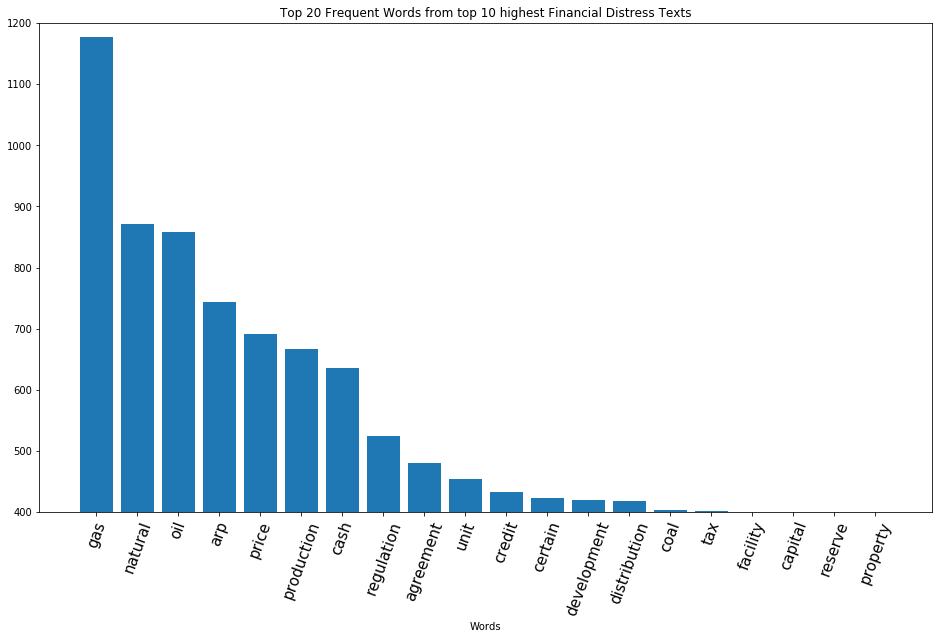

In [86]:
from matplotlib.pyplot import figure
plt.bar(range(len(word_counts_10_high)), word_counts_10_high.values(), align='center')
plt.xlabel('Words', fontsize=10)
plt.xticks(range(len(word_counts_10_high)), word_counts_10_high.keys(), fontsize = 15)
plt.ylim(400, 1200)
plt.xticks(rotation=70)
plt.rcParams["figure.figsize"] = [16,9]
plt.title('Top 20 Frequent Words from top 10 highest Financial Distress Texts')
plt.show()

### Tokenization - [not use]

In [ ]:
%%script false
#Tokenize(split) the sentences into words - only for the 19th item
texts = [[text for text in doc.split()] for doc in risk_factor_text]

In [ ]:
%%script false
# Create dictionary
dictionary = corpora.Dictionary(texts)
print(dictionary)

In [ ]:
%%script false
# Show the word to id map
print(dictionary.token2id)

### Tokenization using gensim 
 - Because this method uses stemming which diminished the characteristics of each token, so I use lemmatization instead, see the next Tokenization cell. 

In [92]:
#check the code running process
from tqdm import tqdm_notebook

In [ ]:
%%script false
# Tokenize(split) the sentences into words
tokenized_list = [gensim.parsing.preprocess_string(doc) for doc in tqdm_notebook(
    risk_factor_text)]

#Default list of filters: strip_tags(), strip_punctuation(), strip_multiple_whitespaces(),
#strip_numeric(),remove_stopwords(),strip_short(),stem_text()

In [ ]:
%%script false
tokenized_list[:5]

### Tokenization using Lemmatization 

In [ ]:
risk_factor_text[0]
#strip_tags(), strip_punctuation(), strip_multiple_whitespaces(),
#strip_numeric(),remove_stopwords(),strip_short()

In [88]:
import spacy
nlp = spacy.load('en')
from gensim.parsing.preprocessing import *

In [ ]:
[w.lemma_ for w in nlp(risk_factor_text[0])]

In [93]:
def new_tokenization_list(texts):
    
    new_tokenization_list = []
    
    CUSTOM_FILTERS = [strip_tags, strip_punctuation,
                      strip_numeric, remove_stopwords, strip_short]
    
    for text in texts:
        
        #tokenization
        tokenized_text = preprocess_string(' '.join([w.lemma_ for w in nlp(text)]), CUSTOM_FILTERS)
        #remove'PRON' got from lemmatization
        tokenized_text = [token for token in tokenized_text if token != 'PRON']
        
        new_tokenization_list.append(tokenized_text)
    
    return new_tokenization_list

new_tokenization_list

<function __main__.new_tokenization_list>

In [94]:
tokenization_list_each_text = new_tokenization_list(tqdm_notebook(risk_factor_text))

A Jupyter Widget

In [95]:
import pickle
with open('tokenization_list_each_text.pickle', 'wb') as f:
    pickle.dump(tokenization_list_each_text, f)

In [96]:
len(tokenization_list_each_text)

11581

In [ ]:
tokenization_list_each_text[0:2]

In [98]:
#remove 20 most frenquent words and 20 lowest frequent words
to_be_removed = ['result','business','product','financial','company','include','operation','market','service',
                 'affect','risk','cost','condition','increase','customer','change','require','future','ability',
                'dispositions\x94','hearing\x94','leif','noteholders\x94','objections','pink\x94','vacate\x94',
                 '\x93confirmation','\x93ds','\x93egc','\x93egc\x94','\x93exxi\x94','\x93fourteenth','\x93mk\x94',
                 '\x93petition','\x93thirteenth','\x93ucc\x94','kanis','ock','\x93\x97historically']
clean_tokenization_list = [[token for token in text if token not in to_be_removed] 
                           for text in tokenization_list_each_text]


### Create a bag of words corpus

In [99]:
#create dictionary
mydict = corpora.Dictionary()

In [100]:
#create dictionary and the Corpus
mydict = corpora.Dictionary()
mycorpus = [mydict.doc2bow(doc, allow_update=True) for doc in clean_tokenization_list]

In [101]:
#save mydict and mycorpus for topic modeling
import pickle

In [102]:
with open('mycorpus.pickle', 'wb') as f:
    pickle.dump(mycorpus, f)

In [103]:
with open('mydict.pickle', 'wb') as handle:
    pickle.dump(mydict, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [ ]:
mycorpus[:1]

In [105]:
#get the original texts back.
word_counts = [[(mydict[id], count)for id, count in line] for line in mycorpus]

#Notice, the order of the words gets lost. Just the word and it’s frequency information \
#is retained.

In [ ]:
word_counts[:1]
#>[[('aarcorp', 1),('abat', 1),('abil', 4),('abl', 5),('abroad', 3),('absent', 1),('accept', 2),('access', 2),
# ('accessori', 2),('accord', 1),('account', 2),('acquir', 8),('acquisit', 6),('act', 4),('action', 2),('activ', 6),
#('actual', 2),('ad', 1),('addit', 8)...

### Word cloud - Unigram

In [107]:
#word cloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [108]:
#create dictionary for all docs
dict_word_counts = {}
for i in word_counts:
    for w, f in i:
        if w not in dict_word_counts.keys():
            dict_word_counts[w] = f
        else:
            dict_word_counts[w] += f

(-0.5, 799.5, 399.5, -0.5)

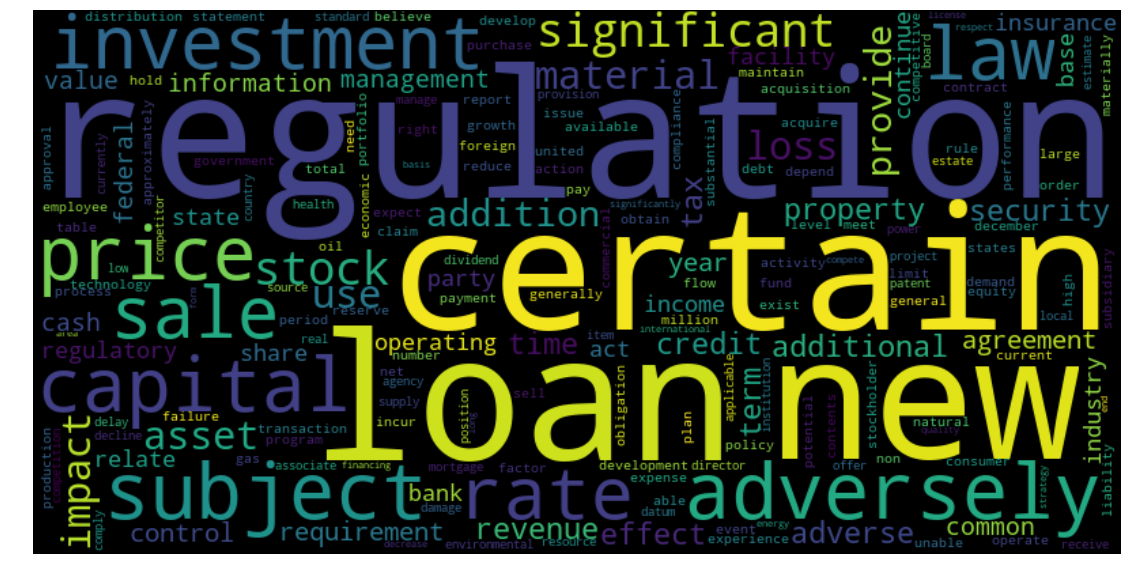

In [109]:
wordcloud = WordCloud(width=800, height=400)
wordcloud.generate_from_frequencies(frequencies=dict_word_counts)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Use 20,000 most frequent words for analysis

In [110]:
#Remove low-frequency words and only include 20,000 most frequent words
unigram_word_counts = list(dict_word_counts.items())
unigram_word_counts[0:10]

[('aarcorp', 1),
 ('abatement', 798),
 ('able', 111209),
 ('abroad', 4022),
 ('absent', 1770),
 ('acceptable', 22682),
 ('access', 62510),
 ('accessory', 2984),
 ('accord', 8143),
 ('account', 60242)]

In [111]:
unigram_word_counts = sorted(unigram_word_counts, key=lambda x: x[1], reverse = True)
len(unigram_word_counts)

100105

In [112]:
#don't run, the result is from the original list
#The 20 most frequent words
unigram_word_counts[0:19]
#[('result', 697735),
#('business', 679676),
 #('product', 558474),
 #('financial', 536258),
 #('company', 525356),
# ('include', 498025),
# ('operation', 482151),
 #('market', 455318),
# ('service', 381384),
# ('affect', 364955),
 #('risk', 356885),
# ('cost', 349497),
 #('condition', 337851),
# ('increase', 330201),
 #('customer', 328018),
 #('change', 307199),
 #('require', 299848),
# ('future', 284657),
 #('ability', 283236)]

[('regulation', 268942),
 ('loan', 268868),
 ('certain', 267733),
 ('new', 267410),
 ('subject', 265420),
 ('adversely', 264854),
 ('capital', 261726),
 ('price', 248077),
 ('investment', 246232),
 ('law', 243039),
 ('rate', 241887),
 ('sale', 231524),
 ('significant', 231195),
 ('stock', 230602),
 ('material', 228512),
 ('asset', 226752),
 ('loss', 219513),
 ('impact', 211987),
 ('use', 211800)]

In [113]:
#don't run, the result is from the original list
#the least 20 frequent words
unigram_word_counts[-20:]
#[('dispositions\x94', 1),
 #('hearing\x94', 1),
 #('leif', 1),
 #('noteholders\x94', 1),
# ('objections', 1),
 #('pink\x94', 1),
# ('vacate\x94', 1),
 #('\x93confirmation', 1),
# ('\x93ds', 1),
 #('\x93egc', 1),
# ('\x93egc\x94', 1),
 #('\x93exxi\x94', 1),
 #('\x93fourteenth', 1),
 #('\x93mk\x94', 1),
 #('\x93petition', 1),
# ('\x93thirteenth', 1),
 #('\x93ucc\x94', 1),
# ('kanis', 1),
 #('ock', 1),
 #('\x93\x97historically', 1)]

[('segregating', 1),
 ('znbr', 1),
 ('pud\x92s', 1),
 ('saltweld', 1),
 ('\x93gom\x94', 1),
 ('creataceous', 1),
 ('cris', 1),
 ('mcmoran\x94', 1),
 ('trend\x94', 1),
 ('\x93apache', 1),
 ('\x93freeport', 1),
 ('xxi\x94', 1),
 ('\x93apache\x94', 1),
 ('\x93fan\x94', 1),
 ('\x93fieldwood\x94', 1),
 ('acquaintance', 1),
 ('\x93exxi', 1),
 ('agent\x94', 1),
 ('bankr', 1),
 ('consensually', 1)]

In [114]:
unigram_word_counts_most_frequent = unigram_word_counts[0:20000]
unigram_word_counts_most_frequent = dict(unigram_word_counts_most_frequent)

(-0.5, 799.5, 399.5, -0.5)

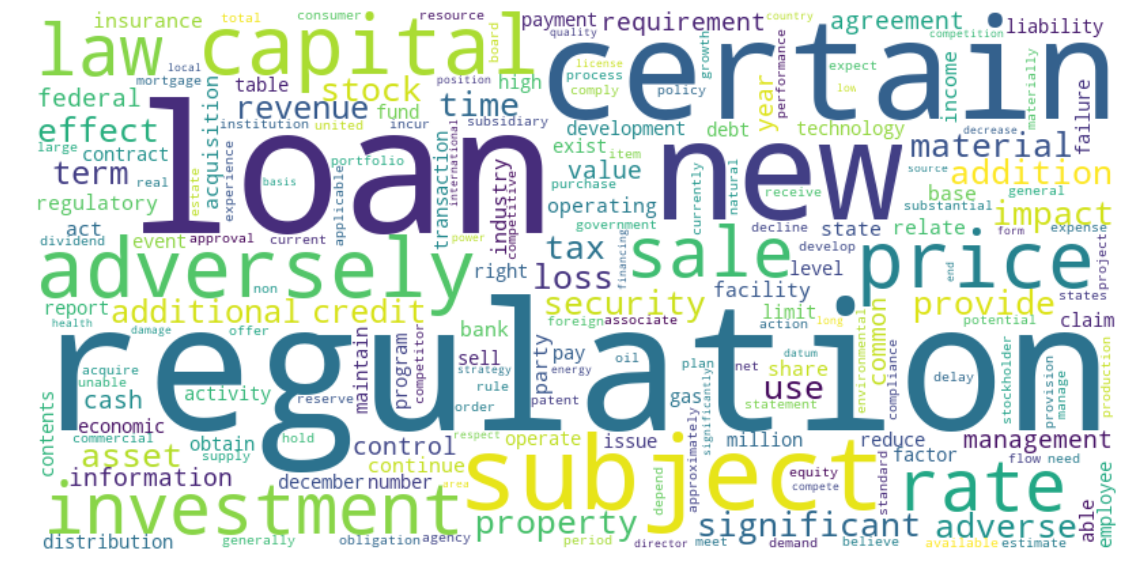

In [115]:
#create word cloud based on the most frequent unigram word counts - 20000
wordcloud = WordCloud(background_color = 'white', width=800, height=400)
wordcloud.generate_from_frequencies(frequencies=unigram_word_counts_most_frequent)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [116]:
#Top 20 words
top_20 = dict(unigram_word_counts[0:19])
top_20 = sorted(top_20.items(), key=lambda x: x[1])
top_20 = dict(top_20)
top_20

{'adversely': 264854,
 'asset': 226752,
 'capital': 261726,
 'certain': 267733,
 'impact': 211987,
 'investment': 246232,
 'law': 243039,
 'loan': 268868,
 'loss': 219513,
 'material': 228512,
 'new': 267410,
 'price': 248077,
 'rate': 241887,
 'regulation': 268942,
 'sale': 231524,
 'significant': 231195,
 'stock': 230602,
 'subject': 265420,
 'use': 211800}

<Container object of 19 artists>

([<matplotlib.axis.XTick at 0x1bc072d470>,
 <a list of 19 Text xticklabel objects>)

(200000, 270000)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text xticklabel objects>)

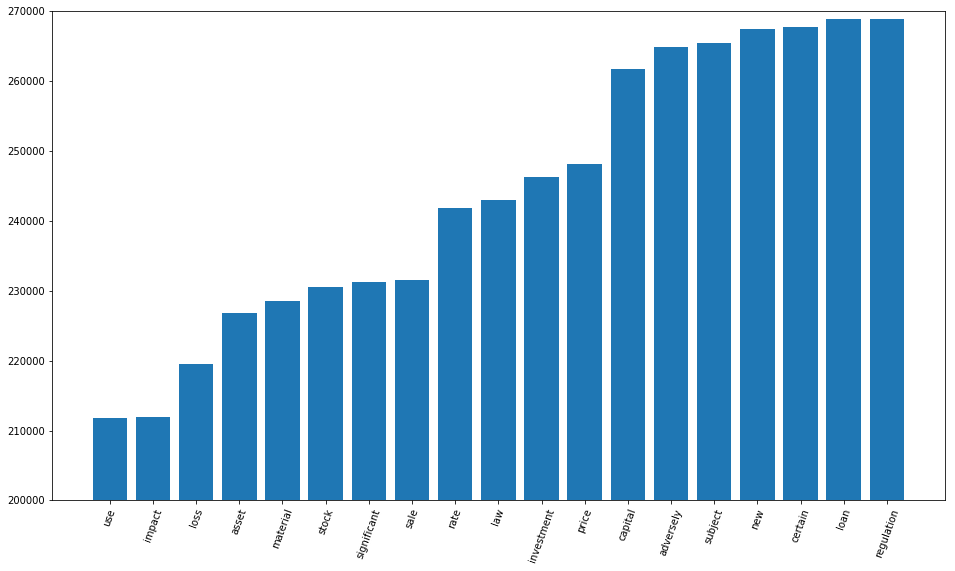

In [119]:
plt.bar(range(len(top_20)), top_20.values(), align='center')
plt.xticks(range(len(top_20)), top_20.keys())
plt.ylim(200000, 270000)
plt.xticks(rotation=70)
plt.show()

### TFIDF

In [120]:
from gensim import models

In [121]:
# TFIDF down weights tokens (words) that appears frequently across documents
##create the TF-IDF model
tfidf = models.TfidfModel(mycorpus, smartirs='ntc')

In [122]:
# Show the TF-IDF weights
for doc in tfidf[mycorpus]:
    tfidf_weight = ([[mydict[id], np.around(freq, decimals = 3)] for id, freq in doc])

In [ ]:
tfidf_weight
#>[['demand', 0.002],
# ['depend', 0.002],
# ['deriv', 0.001],
# ['develop', 0.009],
# ['difficult', 0.002],
# ['disast', 0.001],
# ['discuss', 0.005],
# ['disrupt', 0.0],
# ['drive', 0.004],
# ['driven', 0.004],
# ['duti', 0.024],
# ['econom', 0.001],
# ['effect', 0.006],
# ['emiss', 0.075],
# ['emploi', 0.002],
# ['employe', 0.003],
# ['end', 0.006],
# ['engin', 0.006],
# ['environ', 0.001],
# ['environment', 0.008],

In [ ]:
##tfidf weight sorted by descending
tfidf_weight_dict =dict(tfidf_weight)
sorted_tfidf_weight_dict = sorted(tfidf_weight_dict.items(), key=lambda kv: kv[1], reverse = True)
sorted_tfidf_weight_dict

In [125]:
#top 30 words based on tfidf weight
sorted_tfidf_weight_dict_30 = sorted_tfidf_weight_dict[0:29]
sorted_tfidf_weight_dict_30 = dict(sorted_tfidf_weight_dict_30)
sorted_tfidf_weight_dict_30

{'carb': 0.216,
 'catalyst': 0.405,
 'cdti': 0.053,
 'cerium': 0.074,
 'coat': 0.08,
 'coated': 0.049,
 'earth': 0.051,
 'emission': 0.074,
 'epa': 0.046,
 'honda': 0.33,
 'jointly': 0.047,
 'metal': 0.072,
 'nasdaq': 0.074,
 'patent': 0.067,
 'pgm': 0.343,
 'platinum': 0.152,
 'powder': 0.073,
 'rare': 0.054,
 'reorganization': 0.093,
 'retrofit': 0.078,
 'royalty': 0.066,
 'substrate': 0.07,
 'tanaka': 0.084,
 'tcc': 0.146,
 'territory': 0.059,
 'tkk': 0.563,
 'vehicle': 0.077,
 'verification': 0.117,
 'zpgm\x99': 0.059}

<Container object of 29 artists>

([<matplotlib.axis.XTick at 0x1a6cfad4a8>,
 <a list of 29 Text xticklabel objects>)

(0, 0.6)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 <a list of 29 Text xticklabel objects>)

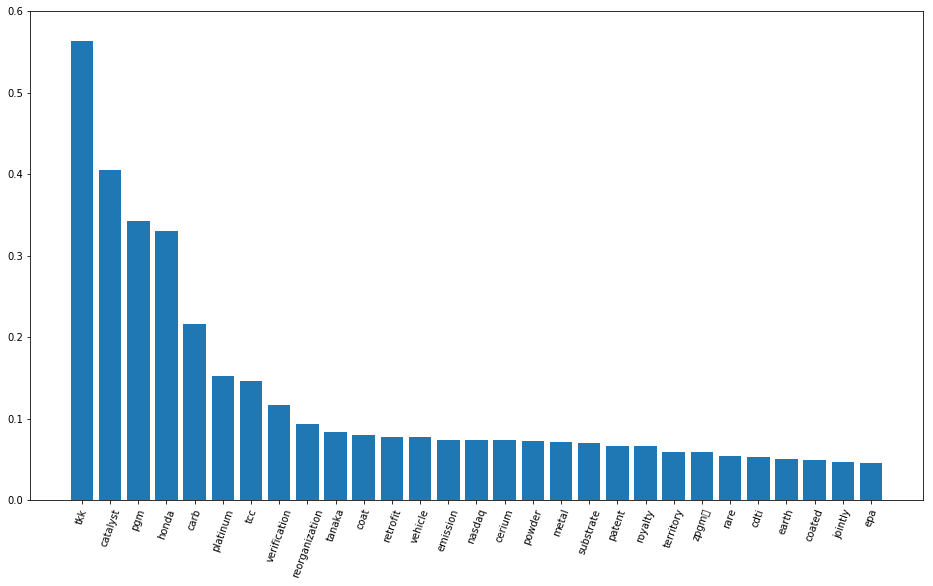

In [126]:
plt.bar(range(len(sorted_tfidf_weight_dict_30)), sorted_tfidf_weight_dict_30.values(), align='center')
plt.xticks(range(len(sorted_tfidf_weight_dict_30)), sorted_tfidf_weight_dict_30.keys())
plt.ylim(0, 0.6)
plt.xticks(rotation=70)
plt.show()

### Phrases

In [1]:
from gensim.models import Phrases

In [9]:
import pickle
with open('tokenization_list_each_text.pickle', 'rb') as f:
    tokenization_list_each_text = pickle.load(f)

In [10]:
# Build the bigram models
bigram = Phrases(tokenization_list_each_text, min_count=20, threshold=10)

In [11]:
bigrams = [bigram[doc] for doc in tokenization_list_each_text]

/Users/iriswang/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
bigrams[:1]

### word cloud - Phrase

In [13]:
from collections import Counter
import itertools

In [14]:
bigrams_word_counts = Counter(itertools.chain(*bigrams))

In [15]:
bigrams_word_counts.most_common(20)

[('result', 697735),
 ('business', 679676),
 ('product', 558474),
 ('financial', 536258),
 ('company', 525356),
 ('include', 498025),
 ('operation', 482151),
 ('market', 455318),
 ('service', 381384),
 ('affect', 364955),
 ('risk', 356885),
 ('cost', 349497),
 ('condition', 337851),
 ('increase', 330201),
 ('customer', 328018),
 ('change', 306528),
 ('require', 299848),
 ('ability', 283236),
 ('future', 279209),
 ('regulation', 268942)]

In [16]:
#remove other stopwords: 'tabl_content', 'year_end', 'fiscal_year'
from nltk.corpus import stopwords
import string

In [17]:
stop_words = stopwords.words('english')
stop_words+=['tabl_content', 'year_end', 'fiscal_year', 'unit_state']

bigrams_word_counts_filtered={word: bigrams_word_counts[word] \
                     for word in bigrams_word_counts \
                     if word not in stop_words}

In [18]:
#filter out words without '_' and leave bigrams phrases only

filtered_bigrams_word_counts = {k:v for (k,v) in bigrams_word_counts_filtered.items() \
                                if '_' in k}

In [19]:
Counter(filtered_bigrams_word_counts).most_common(30)

[('common_stock', 127584),
 ('adverse_effect', 124051),
 ('table_contents', 110764),
 ('cash_flow', 95208),
 ('united_states', 73940),
 ('real_estate', 66750),
 ('natural_gas', 54831),
 ('intellectual_property', 42326),
 ('long_term', 39892),
 ('dodd_frank', 28799),
 ('joint_venture', 25950),
 ('raw_material', 24407),
 ('fair_value', 23981),
 ('oil_natural', 23582),
 ('annual_report', 23222),
 ('clinical_trial', 22894),
 ('board_director', 20954),
 ('forward_look', 19618),
 ('research_development', 18710),
 ('executive_officer', 18642),
 ('board_directors', 17778),
 ('health_care', 17329),
 ('attract_retain', 17045),
 ('foreign_currency', 16716),
 ('natural_disaster', 15699),
 ('short_term', 15292),
 ('taxable_income', 14478),
 ('crude_oil', 14211),
 ('set_forth', 13632),
 ('success_depend', 13183)]

(-0.5, 799.5, 399.5, -0.5)

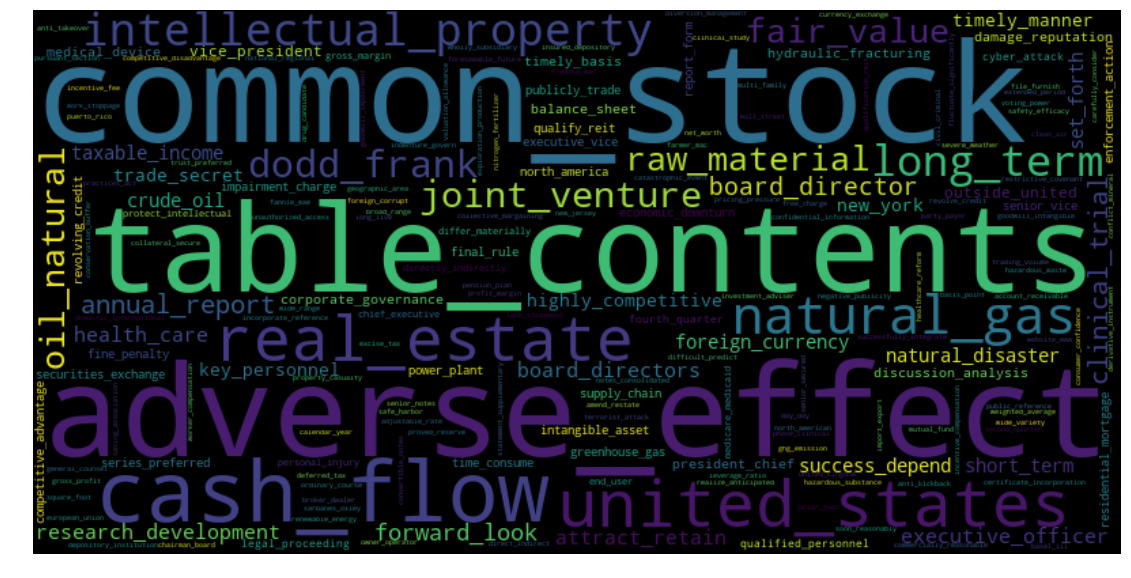

In [20]:
wordcloud = WordCloud(width=800, height=400)
wordcloud.generate_from_frequencies(frequencies=filtered_bigrams_word_counts)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Explore specific words from topic modeling to have an approperate label
 - After went back to the real text using topic words, we can have a better overview on the content of Risk Factor Section and have a more accurate judgement on topic labelling 

In [35]:
#'marine'
marine_text = kmv_data_RiskFactor_sort_filtered[kmv_data_RiskFactor_sort_filtered['risk_factor_text'].str.contains('marine')]

In [ ]:
marine_text['risk_factor_text'][9735]

In [37]:
#medicare
medicare_text = kmv_data_RiskFactor_sort_filtered[kmv_data_RiskFactor_sort_filtered['risk_factor_text'].str.contains('medicare')]

In [ ]:
medicare_text['risk_factor_text'][10543]

In [39]:
medicare_text

,Unnamed: 0,Unnamed: 0.1,gvkey,year,edf,actual_10k_path_raw,risk_factor_text
6509,6509,7288,61302,2013,4.494484e-38,edgar/data/947484/0001047469-13-002083.txt,","" Item 7 ""Management's Discussion and Analysi..."
10543,10543,12101,176760,2014,9.945550e-03,edgar/data/1381531/0001193125-14-064774.txt,** 17 **ITEM 1B** **UNRESOLVED STAFF COMMENTS*...
3622,3622,3876,12874,2015,3.462988e-01,edgar/data/749660/0001193125-15-089682.txt,._ ** We operate in a changing environment tha...
10544,10544,12102,176760,2015,1.166395e-03,edgar/data/1381531/0001193125-15-067221.txt,** 17 **ITEM 1B** **UNRESOLVED STAFF COMMENTS*...
3623,3623,3877,12874,2016,3.856263e-03,edgar/data/749660/0001193125-16-501542.txt,._ ** We operate in a changing environment tha...
9621,9621,10936,162404,2016,1.895101e-04,edgar/data/1303313/0001303313-16-000035.txt,in this Annual Report on Form 10-K or incorpo...
10545,10545,12103,176760,2016,1.688306e-04,edgar/data/1381531/0001564590-16-013475.txt,15 ITEM 1B UNRESOLVED STAFF COMMENTS 23 ITEM ...


In [40]:
#clinical
clinical_text = kmv_data_RiskFactor_sort_filtered[kmv_data_RiskFactor_sort_filtered['risk_factor_text'].str.contains('clinical')]

In [ ]:
clinical_text

In [ ]:
clinical_text['risk_factor_text'][3128]

In [43]:
#ethanol
ethanol_text = kmv_data_RiskFactor_sort_filtered[kmv_data_RiskFactor_sort_filtered['risk_factor_text'].str.contains('ethanol')]

In [ ]:
ethanol_text

In [ ]:
ethanol_text['risk_factor_text'][9701]

In [46]:
# significant , new, adversely, law
law_text = kmv_data_RiskFactor_sort_filtered[kmv_data_RiskFactor_sort_filtered['risk_factor_text'].str.contains('significant|adversely|new|law')]

In [ ]:
law_text

In [ ]:
law_text['risk_factor_text'][5283]